
# U-NO on Darcy-Flow

In this example, we demonstrate how to train a U-shaped Neural Operator on 
the small Darcy-Flow example we ship with the package


In [144]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, UNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

from gc_src.gc_opt import GCOptimizer, WarmupScheduler

device = 'cpu'

Loading the Darcy Flow dataset



In [145]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)



model = UNO(3,1, hidden_channels=64, projection_channels=64,uno_out_channels = [32,64,64,64,32], \
            uno_n_modes= [[16,16],[8,8],[8,8],[8,8],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],\
            horizontal_skips_map = None, n_layers = 5, domain_padding = 0.2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

Loading test db at resolution 32 with 50 samples and batch-size=32

Our model has 2665921 parameters.


Create the optimizer



In [146]:
base_optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-4, 
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(base_optimizer, T_max=30)
#contvar0 = float('nan')
contvar0 = 1e-4
contlr = 5e-1
warmup = 8
optimizer = GCOptimizer(base_optimizer, cont_var0 = contvar0, cont_lr = contlr)
warmupscheduler = WarmupScheduler(optimizer, warmup_epochs = warmup)

Creating the losses



In [147]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [148]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 UNO(
  (domain_padding): DomainPadding()
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (fno_blocks): ModuleList(
    (0): FNOBlocks(
      (convs): SpectralConv(
        (weight): ModuleList(
          (0): ComplexDenseTensor(shape=torch.Size([64, 32, 16, 9]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): FNOBlocks(
      (convs): SpectralConv(
        (weight): ModuleList(
          (0): ComplexDenseTensor(shape=torch.Size([32, 64, 8, 5]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (2): FNOBlocks(
      (convs): SpectralConv(
        (weight): ModuleList(
          (0): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 5]), r

Create the trainer



In [149]:
trainer = Trainer(model=model,
                   n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


Actually train the model on our small Darcy-Flow dataset



In [150]:
'''trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)'''

'trainer.train(train_loader=train_loader,\n              test_loaders=test_loaders,\n              optimizer=optimizer,\n              scheduler=scheduler, \n              regularizer=False, \n              training_loss=train_loss,\n              eval_losses=eval_losses)'

In [151]:
for epoch in range(trainer.n_epochs):
    model.train()
    train_err = 0.0
    train_samples = 0

    for idx, sample in enumerate(train_loader):
        if trainer.data_processor is not None:
            sample = trainer.data_processor.preprocess(sample)
        else:
            # load data to device if no preprocessor exists
            sample = {
                k: v.to(self.device)
                for k, v in sample.items()
                if torch.is_tensor(v)
            }
        
        train_samples += sample["y"].shape[0]

        def closure():
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward
            out = model(**sample)
            loss = train_loss(out, **sample)
            loss.backward()
            del out

            return loss

        loss = optimizer.step(closure)
        train_err += loss.item()

    scheduler.step()
    warmupscheduler.step()

    # test error
    model.eval()
    test_err = 0.0
    test_samples = 0
    test_loader = test_loaders[16]

    for idx, sample in enumerate(test_loader):
        if trainer.data_processor is not None:
            sample = trainer.data_processor.preprocess(sample)
        else:
            # load data to device if no preprocessor exists
            sample = {
                k: v.to(self.device)
                for k, v in sample.items()
                if torch.is_tensor(v)
            }

        test_samples += sample["y"].shape[0]

        with torch.no_grad():
            out = model(**sample)
            loss = eval_losses['h1'](out, **sample)
            test_err += loss.item()
            del out

    train_err /= train_samples
    test_err /= test_samples

    print(f'Epoch {epoch}, train loss: {train_err:.6f}, test loss: {test_err:.6f}, optim contvar: {torch.exp(optimizer.logcontvar).detach():.2e}, optim lr: {optimizer.param_groups[0]["lr"]:.2e}')

with open(f'res_{contvar0:.1e}_{contlr:.1e}_{warmup}.txt', "a") as myfile:
    myfile.write(f'{train_err:.6f}, {test_err:.6f}, {torch.exp(optimizer.logcontvar).detach():.2e}\n')


Epoch 0, train loss: 0.655308, test loss: 0.446093, optim contvar: 1.00e-04, optim lr: 7.98e-04
Epoch 1, train loss: 0.377916, test loss: 0.361255, optim contvar: 1.00e-04, optim lr: 7.91e-04
Epoch 2, train loss: 0.324650, test loss: 0.310732, optim contvar: 1.00e-04, optim lr: 7.80e-04
Epoch 3, train loss: 0.298744, test loss: 0.299271, optim contvar: 1.00e-04, optim lr: 7.65e-04
Epoch 4, train loss: 0.282271, test loss: 0.292643, optim contvar: 1.00e-04, optim lr: 7.46e-04
Epoch 5, train loss: 0.279757, test loss: 0.261308, optim contvar: 1.00e-04, optim lr: 7.24e-04
Epoch 6, train loss: 0.263187, test loss: 0.256279, optim contvar: 1.00e-04, optim lr: 6.97e-04
Epoch 7, train loss: 0.267942, test loss: 0.257608, optim contvar: 1.00e-04, optim lr: 6.68e-04
Epoch 8, train loss: 0.238976, test loss: 0.232468, optim contvar: 2.46e-07, optim lr: 6.35e-04
Epoch 9, train loss: 0.221806, test loss: 0.237826, optim contvar: 1.63e-07, optim lr: 6.00e-04
Epoch 10, train loss: 0.220608, test los

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



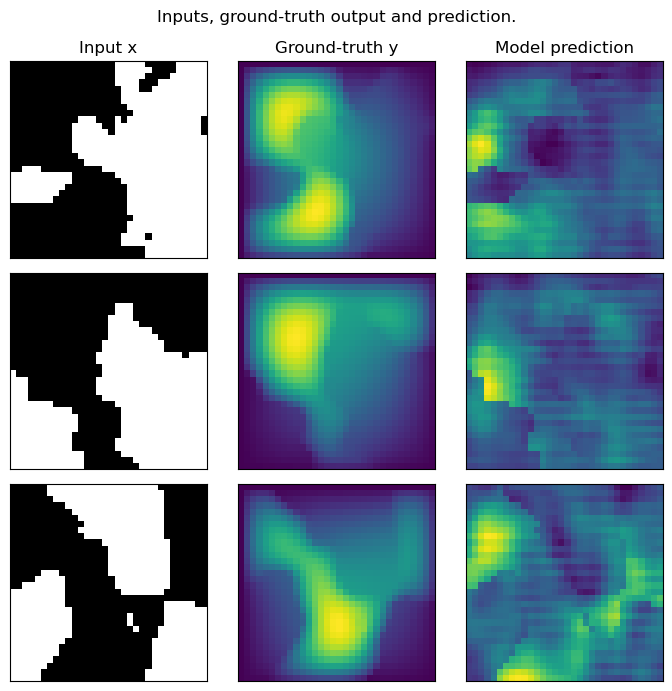

In [152]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).to(device)).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()